This notebook will apply a general linear regression model to the data

In [22]:
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
from data_utils import load_dataset, core_metrics, map_model

import plotly.io as pio
# set this to 'jupyterlab' for interactive
pio.renderers.default = "png" 

In [3]:
X_train, X_test, y_train, y_test, X_scaler = load_dataset(scale=True,one_hot=True,categorize_bedrooms=True)

X Columns: {} Index(['date', 'latitude', 'longitude', 'area', 'pets', 'furnished',
       'unit_type_apartment', 'unit_type_condo', 'unit_type_house',
       'unit_type_townhouse', 'bedrooms_0.0', 'bedrooms_1.0', 'bedrooms_2.0',
       'bedrooms_3.0', 'bedrooms_4.0', 'bedrooms_5.0', 'bedrooms_6.0',
       'bedrooms_7.0', 'bedrooms_8.0'],
      dtype='object')
X Shape: (306414, 19)
y Shape: (306414, 1)


In [4]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# # Load the diabetes dataset
# diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean absolute error: %.2f' % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [[  43.74611422  166.39408319 -273.47055115  719.84402825  208.21393885
   208.21393885   17.22284589  348.74421876 -427.77508841   61.80802376
  -525.66218079 -337.80159155  120.91634019  314.46203103  198.45185779
   229.88574899  203.97292034   46.05599032 -250.28111631]]
Mean absolute error: 422.52
Coefficient of determination: 0.68


Plotting only 16/19 variables
date: y = 43.746114*date
latitude: y = 166.394083*latitude
longitude: y = -273.470551*longitude
area: y = 719.844028*area
pets: y = 208.213939*pets
furnished: y = 208.213939*furnished
unit_type_apartment: y = 17.222846*unit_type_apartment
unit_type_condo: y = 348.744219*unit_type_condo
unit_type_house: y = -427.775088*unit_type_house
unit_type_townhouse: y = 61.808024*unit_type_townhouse
bedrooms_0.0: y = -525.662181*bedrooms_0.0
bedrooms_1.0: y = -337.801592*bedrooms_1.0
bedrooms_2.0: y = 120.916340*bedrooms_2.0
bedrooms_3.0: y = 314.462031*bedrooms_3.0
bedrooms_4.0: y = 198.451858*bedrooms_4.0


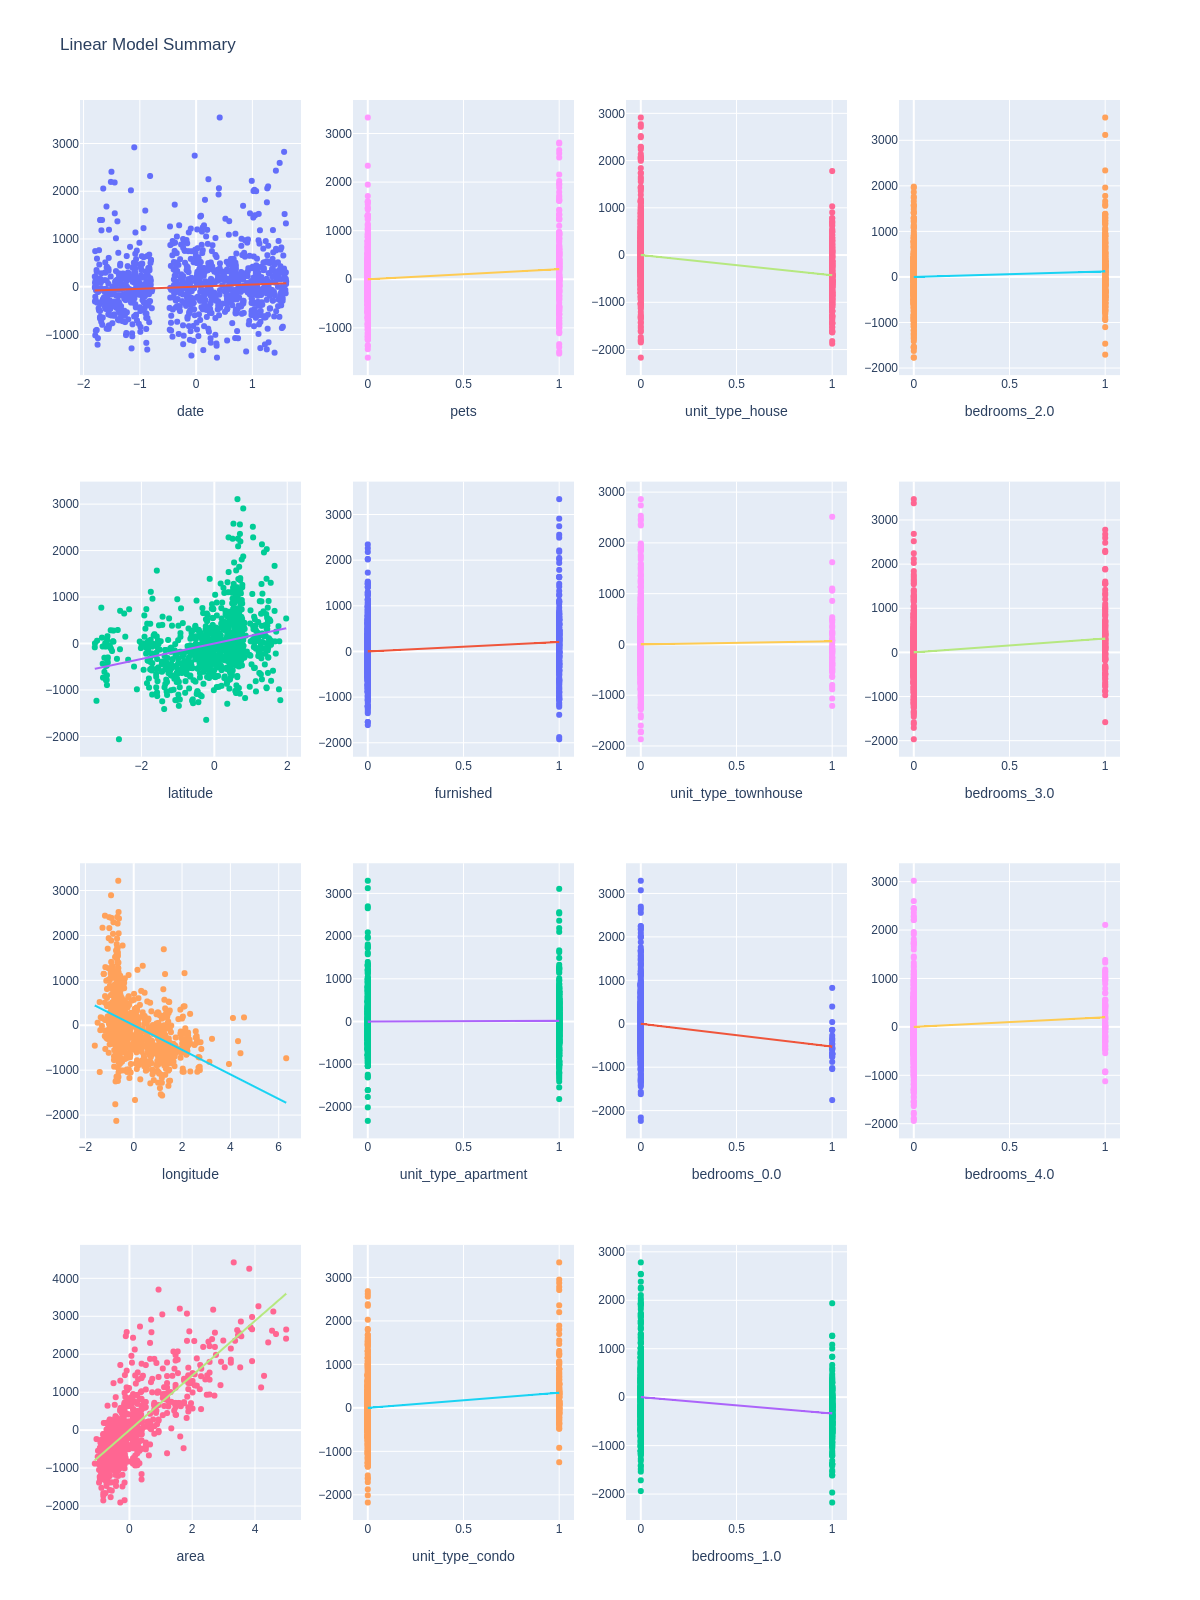

In [19]:
# visualize results
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from sklearn import linear_model, datasets

# diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# regr = linear_model.LinearRegression()

## Train the model using the training sets
# regr.fit(diabetes_X, diabetes_y)

## Make predictions using the testing set
# y_pred = regr.predict(diabetes_X)

# plot_lin_reg(diabetes_X,diabetes_y,regr)

def plot_lin_reg (X,y,regr,x_columns=[],y_columns=[]):
    # put stuff into a df
    X = X.to_numpy()
    y = y.to_numpy()
    data = np.concatenate((X,y),axis=1)
    x_columns = x_columns or list(map(lambda x: "x_" + str(x),range(X.shape[1])))
    y_columns = y_columns or list(map(lambda x: "y_" + str(x),range(y.shape[1])))
    df = pd.DataFrame(data=data,columns=x_columns+y_columns)
    
    # make predictions
    y_pred = regr.predict(X)
    df['y_pred'] = y_pred
    
    num_columns = len(x_columns)
    grid_size = int(np.ceil(np.sqrt(num_columns)))
    if grid_size > 4:
        print("Plotting only 16/{} variables".format(num_columns))
        grid_size = 4
        x_columns = x_columns[0:15]
        num_columns = 16
        #X = X[x_columns]
    fig = make_subplots(rows=grid_size,cols=grid_size)
    row = 1
    col = 1
    y_name = y_columns[0]
    
    for i,col_name in enumerate(x_columns):
    
        # control the data for all the other variables than the one we are looking at
        X_control = np.copy(X)
        X_control[:,i] = np.zeros(X.shape[0]) # set the variable to zeros
        control = regr.predict(X_control)# - regr.intercept_
        y_control = y - control # subtract off the effects of the other variables
        df['y_control'] = y_control
    
        # plot the line for just the active variable
        X_regr = np.zeros(X.shape)
        X_regr[:,i] = X[:,i]
        y_regr = regr.predict(X_regr) - regr.intercept_[0]
        df['y_regr'] = y_regr 
    
        print("{}: y = {:3f}*{}".format(col_name,regr.coef_[0][i],col_name))
    
        # residuals
    
        residuals = y_regr - y_control
        df['residuals'] = residuals
    
        # finally, let's plot it all

        plot_data = df.sample(n=1000,axis=0) if len(df) > 1000 else df # if there are more than 1,000 points, just use a sample
        plot_data = plot_data.sort_values(by=col_name)
    
    
        #fig.add_trace(go.Scatter(x=plot_data[col_name],y=plot_data['price'],name='Real Price',mode='markers',visible='legendonly'),row=row,col=col)
        fig.add_trace(go.Scatter(x=plot_data[col_name],y=plot_data['y_control'],mode='markers',name='{} (controlled)'.format(y_name)),row=row,col=col)
        fig.add_trace(go.Scatter(x=plot_data[col_name],y=plot_data['y_regr'],mode='lines',name='Linear fit'),row=row,col=col)
        #fig.add_trace(go.Scatter(x=plot_data['area'],y=plot_data['residuals'],mode='markers',name='Residuals'),row=2,col=1)
        #fig.update_yaxes(title_text="Price ($)", row=row, col=col)
        fig.update_xaxes(title_text=col_name, row=row, col=col)
        
        #fig.update_yaxes(title_text="Price ($)", row=2, col=1)
        
        if row < grid_size:
            row = row + 1
        else:
            row = 1
            col = col + 1
            
    fig.update_layout(title='Linear Model Summary')
    fig.update_layout(showlegend=False)
    fig.show(height=1600,width=1200,renderer='png')

col_names = list(X_test.columns)
plot_lin_reg(X_test,y_test,regr,x_columns=col_names,y_columns=['price'])

Mean Absolute Error: 423
Median Absolute Error: 311
Explained Variance: 0.68


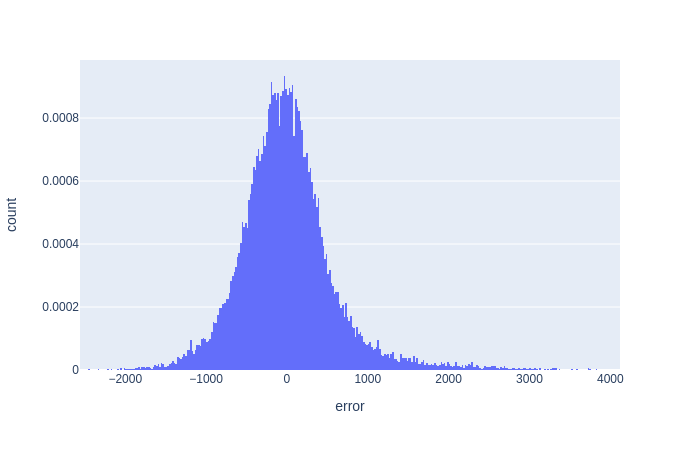

In [23]:
core_metrics(y_test, y_pred)

Using cached coordinates


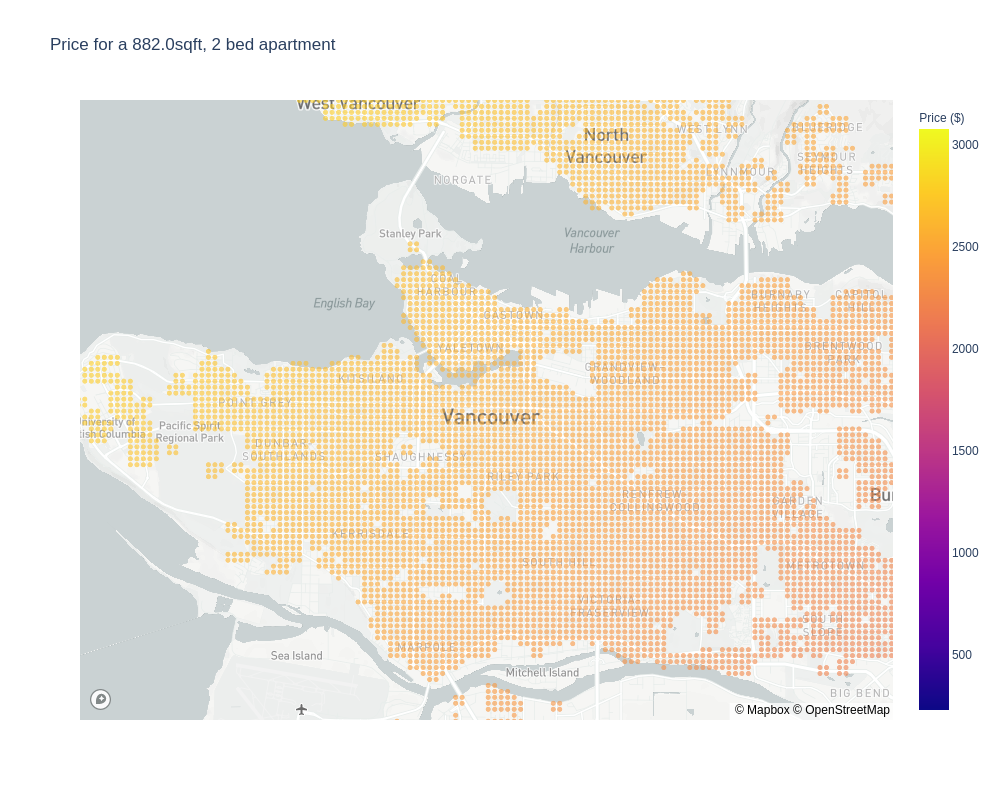

In [25]:
fig = map_model(X_train,regr,scaler=X_scaler)
fig.show(height=800,width=1000)